=== 极端天气预警间隔时间预测模型 ===

1. 加载和预处理数据...
数据加载完成，共 467 条发布记录

2. 构建预警间隔时间数据集...
正在计算历史特征...
成功构建 163 条预警间隔记录
主要预警类型分布:
预警类型
暴雨      59
雷电      37
雷雨大风    31
高温      12
台风      10
森林火险    10
强季风      4
Name: count, dtype: int64

3. 进行探索性数据分析...

4. 构建回归模型...
用于建模的数据量: 127

随机森林模型评估:
  交叉验证R²: 0.6602 ± 0.1293
  测试集R²: 0.5665
  MSE: 157.05, MAE: 8.26

梯度提升模型评估:
  交叉验证R²: 0.5985 ± 0.2337
  测试集R²: 0.5861
  MSE: 149.95, MAE: 8.33

XGBoost模型评估:
  交叉验证R²: 0.4618 ± 0.4725
  测试集R²: 0.3348
  MSE: 240.96, MAE: 10.11

最重要的特征:
           特征       重要性
9   过去30天预警次数  0.809866
8      历史平均间隔  0.113463
7    前次预警级别编码  0.020749
6          月份  0.017252
5       季节_秋季  0.010840
1     预警类型_雷电  0.010157
4       季节_春季  0.007290
3       季节_夏季  0.004399
2   预警类型_雷雨大风  0.003348
10      是否工作日  0.002233
最佳模型已保存为 'best_warning_interval_model.pkl'

5. 模型应用示例...

预测结果:
   预测间隔时间(天)                   预测下次预警日期 预警类型 前次预警级别
0          6 2026-01-08 01:05:22.533820   暴雨     黄色
1          9 2026-01-11 01:05:22.533820   台风     蓝色


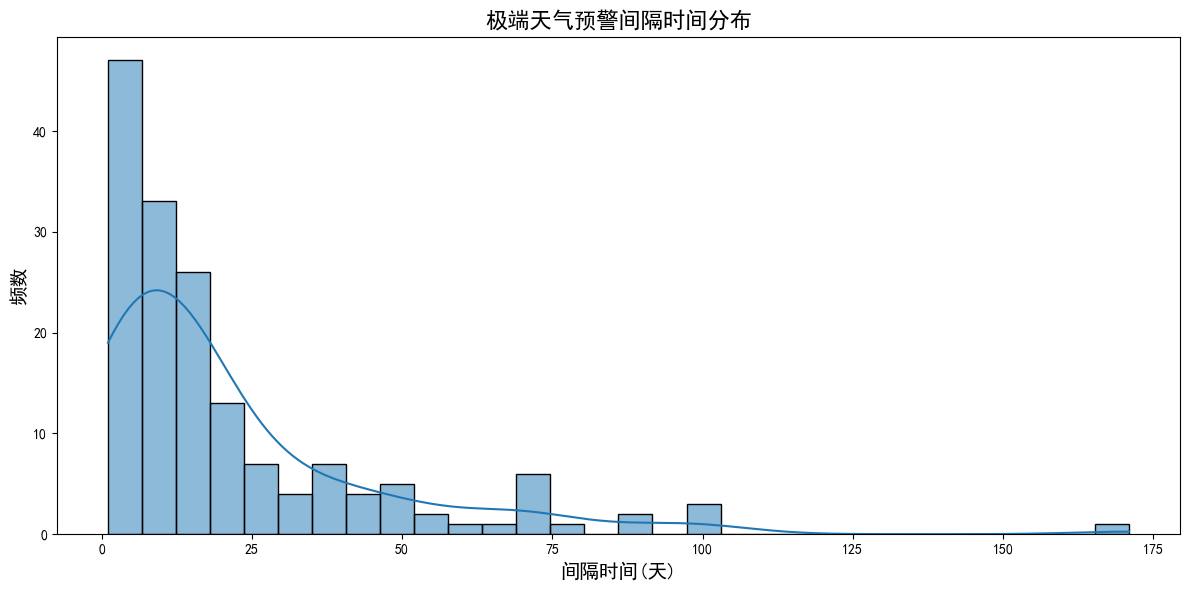

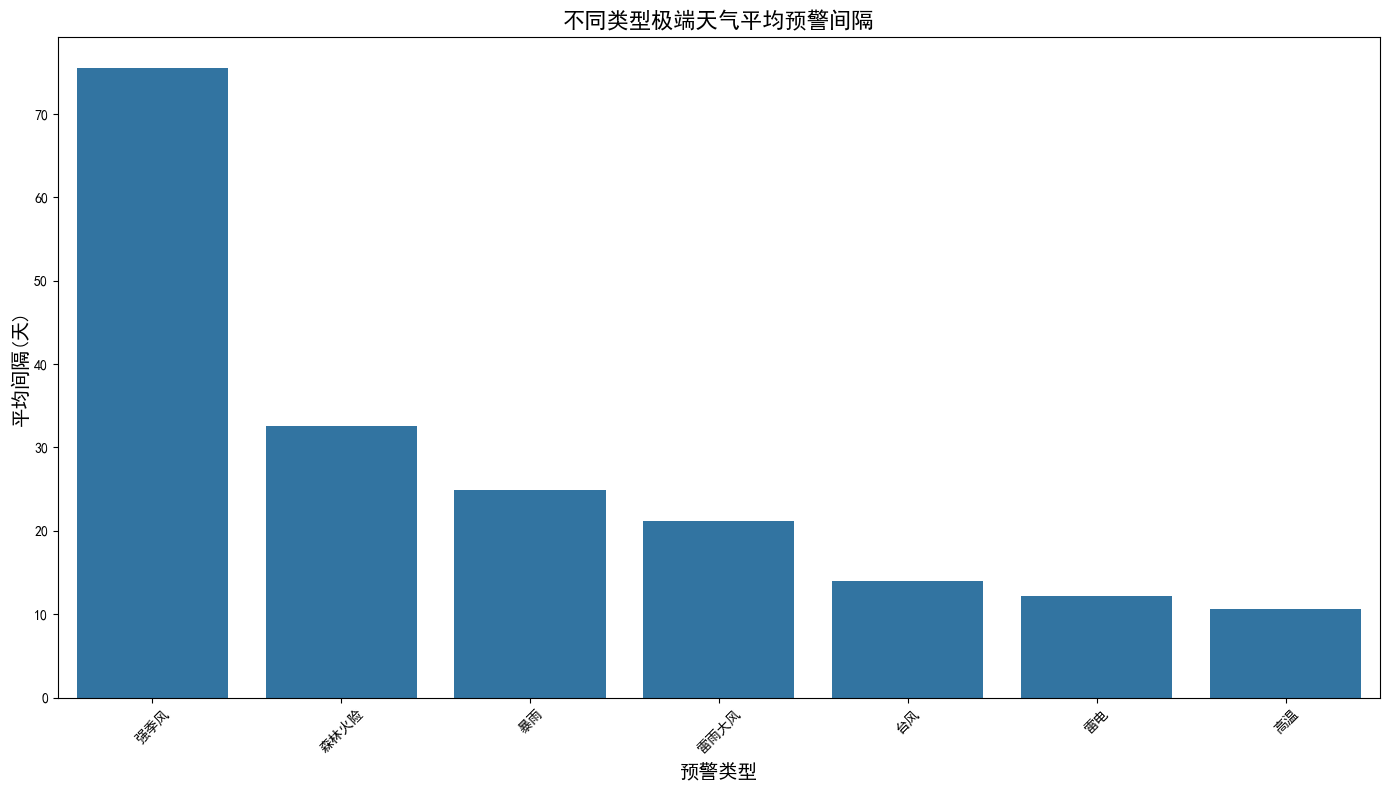

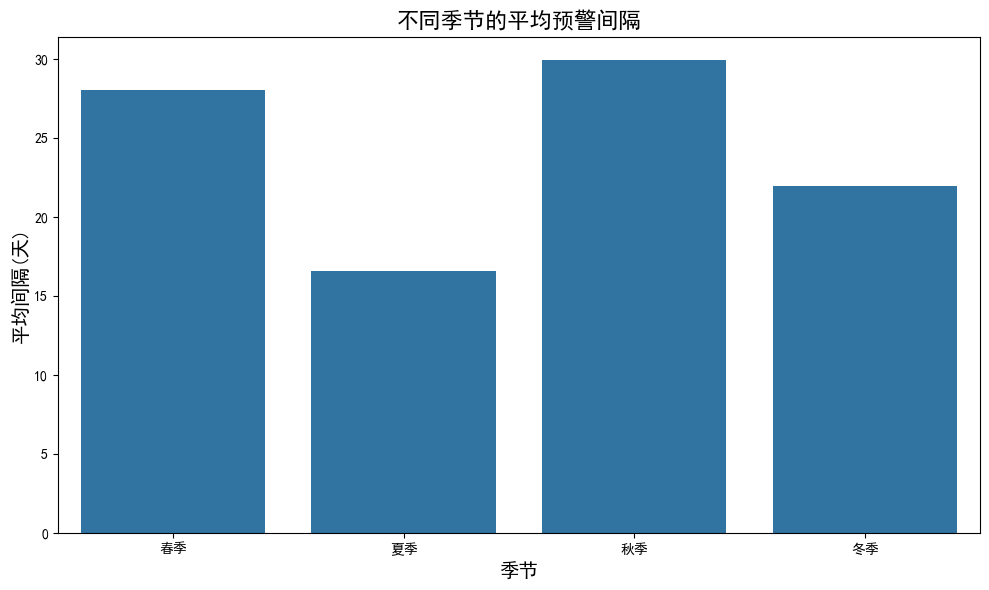

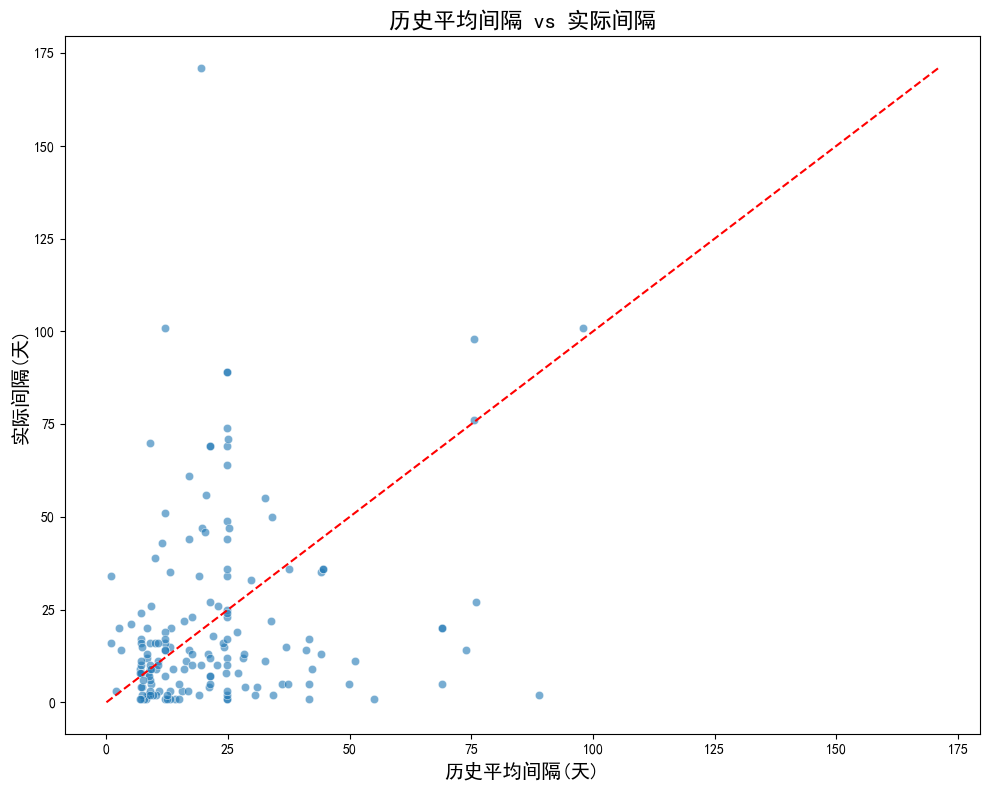

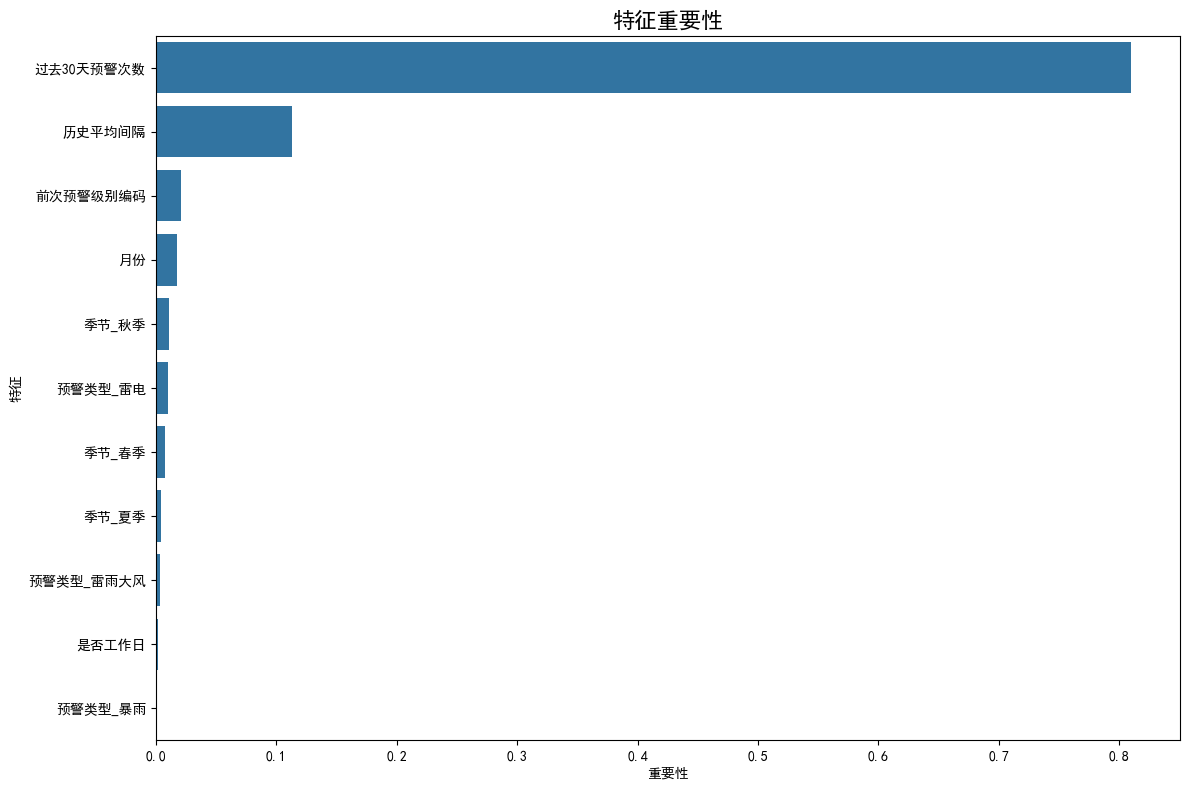

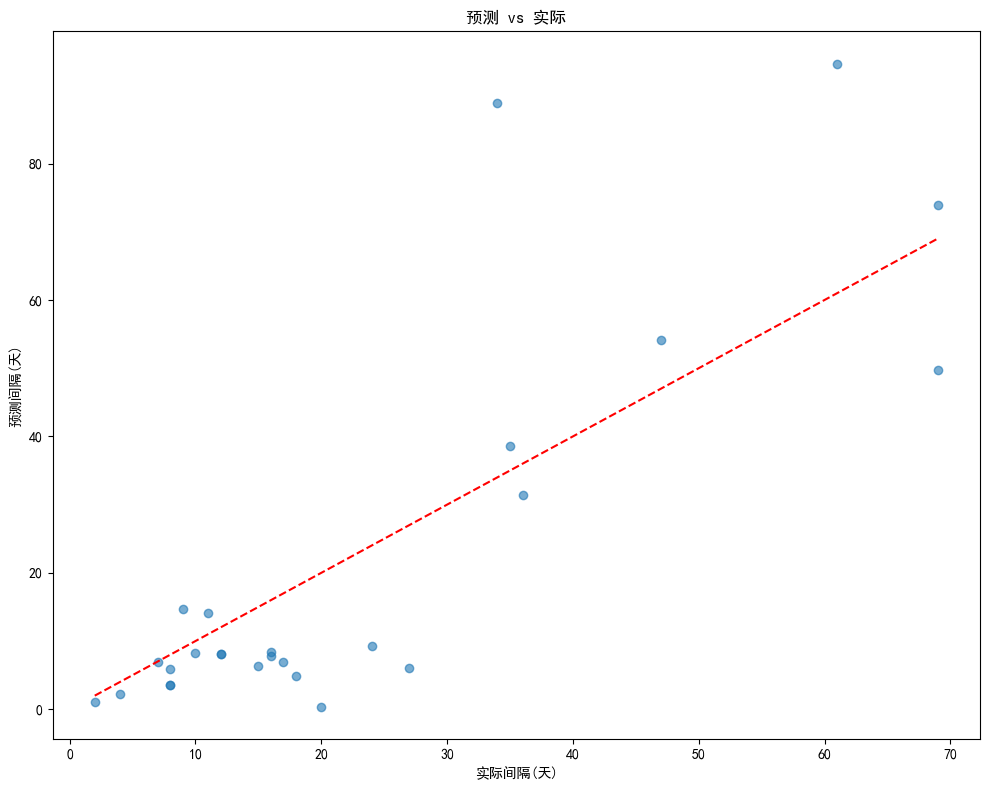

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib中文支持
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载与预处理
def load_and_preprocess_data():
    """加载数据并进行基础预处理"""
    df = pd.read_csv('预报预警数据_灾害性天气预警_2920000900329 - 1年.csv')
    
    # 清理发布时间
    df['发布时间'] = df['发布时间'].str.strip().str.replace('\t', '', regex=False)
    df['发布时间'] = pd.to_datetime(df['发布时间'], errors='coerce')
    
    # 清理区域
    def clean_region(region):
        if pd.isna(region) or region == '-' or region == '':
            return '未知区域'
        region = str(region).replace('、', ',').replace('；', ',').replace(' ', '')
        region = region.replace('全市陆地', '全市')
        regions = [r.strip() for r in region.split(',') if r.strip() != '']
        return ','.join(regions[:3])  # 只保留前3个主要区域
    
    df['clean_region'] = df['信号影响区域'].apply(clean_region)
    
    # 只保留发布记录
    publish_df = df[df['发布状态(发布/取消)'] == '发布'].copy()
    
    # 确保时间非空
    publish_df = publish_df.dropna(subset=['发布时间'])
    
    return publish_df

# 2. 构建预警间隔时间数据集
def create_warning_interval_dataset(df):
    """创建预警间隔时间数据集"""
    
    # 按类型、级别、区域、时间排序
    df = df.sort_values(['信号类型', '信号级别', 'clean_region', '发布时间']).reset_index(drop=True)
    
    interval_data = []
    
    # 按预警类型分组
    for weather_type, type_group in df.groupby('信号类型'):
        if len(type_group) < 10:
            continue
            
        # 按区域进一步分组
        for region, region_group in type_group.groupby('clean_region'):
            if len(region_group) < 3:
                continue
                
            # 排序并遍历
            region_group = region_group.sort_values('发布时间').reset_index(drop=True)
            
            for i in range(1, len(region_group)):
                prev_row = region_group.iloc[i-1]
                curr_row = region_group.iloc[i]
                
                # 安全转换为 datetime（应已是 Timestamp，但再保险）
                prev_time = pd.to_datetime(prev_row['发布时间'])
                curr_time = pd.to_datetime(curr_row['发布时间'])
                
                # 计算间隔天数
                interval_days = (curr_time - prev_time).days
                
                # 只考虑合理的间隔（1-180天）
                if 1 <= interval_days <= 180:
                    interval_data.append({
                        '预警类型': weather_type,
                        '影响区域': region,
                        '前次预警级别': prev_row['信号级别'],
                        '当前预警级别': curr_row['信号级别'],
                        '时间间隔(天)': interval_days,
                        '月份': curr_time.month,
                        '季节': '春季' if curr_time.month in [3,4,5] else (
                               '夏季' if curr_time.month in [6,7,8] else (
                               '秋季' if curr_time.month in [9,10,11] else '冬季')),
                        '当前预警时间': curr_time,
                        '前次预警时间': prev_time,
                        '是否工作日': 1 if curr_time.dayofweek < 5 else 0,
                        '历史平均间隔': None,  # 后面会计算
                        '过去30天预警次数': None  # 后面会计算
                    })
    
    if not interval_data:
        print("警告：未生成任何预警间隔记录！请检查数据或调整过滤条件。")
        return pd.DataFrame()
    
    interval_df = pd.DataFrame(interval_data)
    
    # 添加历史特征
    print("正在计算历史特征...")
    for idx, row in interval_df.iterrows():
        # 历史平均间隔
        historical = interval_df[
            (interval_df['预警类型'] == row['预警类型']) &
            (interval_df['影响区域'] == row['影响区域']) &
            (interval_df['当前预警时间'] < row['当前预警时间'])
        ]
        
        if len(historical) > 0:
            avg_interval = historical['时间间隔(天)'].mean()
        else:
            # 全局平均（同类型）
            global_avg = interval_df[interval_df['预警类型'] == row['预警类型']]['时间间隔(天)'].mean()
            avg_interval = global_avg if not pd.isna(global_avg) else 30
        
        interval_df.at[idx, '历史平均间隔'] = avg_interval
        
        # 过去30天预警次数（从原始 df 中统计）
        past_date = row['当前预警时间'] - pd.Timedelta(days=30)
        count = df[
            (df['信号类型'] == row['预警类型']) &
            (df['clean_region'] == row['影响区域']) &
            (df['发布时间'] >= past_date) &
            (df['发布时间'] < row['当前预警时间'])
        ].shape[0]
        interval_df.at[idx, '过去30天预警次数'] = count
    
    return interval_df

# 3. 探索性数据分析
def perform_eda(interval_df):
    """进行探索性数据分析"""
    if interval_df.empty:
        print("EDA 跳过：数据集为空")
        return interval_df
        
    # 1. 预警间隔分布
    plt.figure(figsize=(12, 6))
    sns.histplot(interval_df['时间间隔(天)'], bins=30, kde=True)
    plt.title('极端天气预警间隔时间分布', fontsize=16)
    plt.xlabel('间隔时间(天)', fontsize=14)
    plt.ylabel('频数', fontsize=14)
    plt.tight_layout()
    plt.savefig('interval_distribution.png')
    
    # 2. 不同类型预警的平均间隔
    plt.figure(figsize=(14, 8))
    type_intervals = interval_df.groupby('预警类型')['时间间隔(天)'].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=type_intervals.index, y=type_intervals.values)
    plt.title('不同类型极端天气平均预警间隔', fontsize=16)
    plt.xlabel('预警类型', fontsize=14)
    plt.ylabel('平均间隔(天)', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('interval_by_type.png')
    
    # 3. 季节性分析
    plt.figure(figsize=(10, 6))
    seasonal_intervals = interval_df.groupby('季节')['时间间隔(天)'].mean()
    season_order = ['春季', '夏季', '秋季', '冬季']
    sns.barplot(x=seasonal_intervals.index, y=seasonal_intervals.values, order=season_order)
    plt.title('不同季节的平均预警间隔', fontsize=16)
    plt.xlabel('季节', fontsize=14)
    plt.ylabel('平均间隔(天)', fontsize=14)
    plt.tight_layout()
    plt.savefig('interval_by_season.png')
    
    # 4. 历史平均间隔与实际间隔的相关性
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=interval_df, x='历史平均间隔', y='时间间隔(天)', alpha=0.6)
    max_val = max(interval_df['历史平均间隔'].max(), interval_df['时间间隔(天)'].max())
    plt.plot([0, max_val], [0, max_val], 'r--')
    plt.title('历史平均间隔 vs 实际间隔', fontsize=16)
    plt.xlabel('历史平均间隔(天)', fontsize=14)
    plt.ylabel('实际间隔(天)', fontsize=14)
    plt.tight_layout()
    plt.savefig('historical_vs_actual_interval.png')
    
    return interval_df

# 4. 构建回归模型
def build_regression_model(interval_df):
    """构建预测预警间隔时间的回归模型"""
    if interval_df.empty or len(interval_df) < 50:
        print("建模跳过：样本量不足")
        return None, {}, None, None
        
    # 1. 筛选高频类型
    type_counts = interval_df['预警类型'].value_counts()
    valid_types = type_counts[type_counts >= 20].index.tolist()
    filtered_df = interval_df[interval_df['预警类型'].isin(valid_types)].copy()
    print(f"用于建模的数据量: {len(filtered_df)}")
    
    if len(filtered_df) < 50:
        print("警告: 样本量不足，考虑合并预警类型或扩展时间范围")
    
    # 2. 预警级别编码
    level_mapping = {'白色': 1, '蓝色': 2, '黄色': 3, '橙色': 4, '红色': 5}
    filtered_df['前次预警级别编码'] = filtered_df['前次预警级别'].map(level_mapping)
    filtered_df['当前预警级别编码'] = filtered_df['当前预警级别'].map(level_mapping)
    
    # 3. 填充缺失级别（如有）
    filtered_df['前次预警级别编码'].fillna(2, inplace=True)  # 默认蓝色
    filtered_df['当前预警级别编码'].fillna(2, inplace=True)
    
    # 4. 特征与目标
    features = ['预警类型', '月份', '季节', '前次预警级别编码', 
                '历史平均间隔', '过去30天预警次数', '是否工作日']
    target = '时间间隔(天)'
    
    X = filtered_df[features]
    y = filtered_df[target]
    
    # 5. 处理缺失（数值列用均值，分类用“未知”）
    X = X.copy()
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].fillna('未知')
        else:
            X[col] = X[col].fillna(X[col].mean())
    
    # 6. 特征工程管道
    categorical_features = ['预警类型', '季节']
    numerical_features = [f for f in features if f not in categorical_features]
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, categorical_features),
            ('num', numerical_transformer, numerical_features)
        ])
    
    # 7. 模型训练与评估
    models = {
        '随机森林': RandomForestRegressor(n_estimators=100, random_state=42),
        '梯度提升': GradientBoostingRegressor(random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42)
    }
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    results = {}
    best_model = None
    best_score = -np.inf
    
    for name, model in models.items():
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        cv_mean, cv_std = cv_scores.mean(), cv_scores.std()
        
        print(f"\n{name}模型评估:")
        print(f"  交叉验证R²: {cv_mean:.4f} ± {cv_std:.4f}")
        print(f"  测试集R²: {r2:.4f}")
        print(f"  MSE: {mse:.2f}, MAE: {mae:.2f}")
        
        results[name] = {
            '模型': pipeline,
            'R²': r2,
            'MSE': mse,
            'MAE': mae,
            'CV_R²': cv_mean,
            'CV_std': cv_std
        }
        
        if r2 > best_score:
            best_score = r2
            best_model = pipeline
    
    # 8. 特征重要性（仅对树模型）
    if best_model and hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
        cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat']
        try:
            cat_names = cat_encoder.named_steps['onehot'].get_feature_names_out(categorical_features)
        except:
            cat_names = cat_encoder.steps[-1][1].get_feature_names_out(categorical_features)
        all_names = list(cat_names) + numerical_features
        importances = best_model.named_steps['regressor'].feature_importances_
        
        feat_imp = pd.DataFrame({'特征': all_names, '重要性': importances}).sort_values('重要性', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='重要性', y='特征', data=feat_imp.head(15))
        plt.title('特征重要性', fontsize=16)
        plt.tight_layout()
        plt.savefig('feature_importance_interval.png')
        print("\n最重要的特征:")
        print(feat_imp.head(10))
    
    # 9. 预测结果图
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('实际间隔(天)')
    plt.ylabel('预测间隔(天)')
    plt.title('预测 vs 实际')
    plt.tight_layout()
    plt.savefig('prediction_vs_actual_interval.png')
    
    return best_model, results, X_test, y_test

# 5. 预测函数
def predict_next_warning_interval(model, input_data):
    """预测下一次预警的间隔时间"""
    if model is None:
        print("模型为空，无法预测")
        return pd.DataFrame()
    
    # 统一转换为 DataFrame
    if isinstance(input_data, dict):
        input_df = pd.DataFrame([input_data])
    elif isinstance(input_data, list):
        input_df = pd.DataFrame(input_data)  
    elif isinstance(input_data, pd.DataFrame):
        input_df = input_data.copy()
    else:
        raise ValueError("input_data 必须是 dict、list of dict 或 DataFrame")
    
    # 预警级别编码
    level_mapping = {'白色': 1, '蓝色': 2, '黄色': 3, '橙色': 4, '红色': 5}
    if '前次预警级别编码' not in input_df.columns:
        input_df['前次预警级别编码'] = input_df['前次预警级别'].map(level_mapping).fillna(2)
    
    # 默认历史特征（简化）
    type_avg = {
        '暴雨': 15, '台风': 45, '强季风': 30, '雷电': 10,
        '雷雨大风': 12, '森林火险': 60, '高温': 20,
        '寒冷': 35, '大雾': 25
    }
    input_df['历史平均间隔'] = input_df['预警类型'].map(type_avg).fillna(30)
    input_df['过去30天预警次数'] = input_df['预警类型'].map({
        '暴雨': 3, '台风': 1, '强季风': 2, '雷电': 5,
        '雷雨大风': 4, '森林火险': 2, '高温': 3,
        '寒冷': 1, '大雾': 2
    }).fillna(2)
    
    # 选择特征
    features = ['预警类型', '月份', '季节', '前次预警级别编码', 
                '历史平均间隔', '过去30天预警次数', '是否工作日']
    X_pred = input_df[features]
    
    # 预测
    predicted_intervals = model.predict(X_pred)
    
    # 构造结果
    results = []
    for i, interval in enumerate(predicted_intervals):
        current_date = input_df.iloc[i].get('当前日期', datetime.now())
        results.append({
            '预测间隔时间(天)': max(1, round(interval)),
            '预测下次预警日期': current_date + timedelta(days=round(interval)),
            '预警类型': input_df.iloc[i]['预警类型'],
            '前次预警级别': input_df.iloc[i]['前次预警级别']
        })
    
    return pd.DataFrame(results)

# 6. 主函数
def main():
    print("=== 极端天气预警间隔时间预测模型 ===")
    
    # 1. 加载和预处理数据
    print("\n1. 加载和预处理数据...")
    df = load_and_preprocess_data()
    print(f"数据加载完成，共 {len(df)} 条发布记录")
    
    # 2. 构建预警间隔时间数据集
    print("\n2. 构建预警间隔时间数据集...")
    interval_df = create_warning_interval_dataset(df)
    print(f"成功构建 {len(interval_df)} 条预警间隔记录")
    if len(interval_df) > 0:
        print("主要预警类型分布:")
        print(interval_df['预警类型'].value_counts())
    else:
        print("未生成有效间隔记录，程序将提前结束。")
        return
    
    # 3. EDA
    print("\n3. 进行探索性数据分析...")
    interval_df = perform_eda(interval_df)
    
    # 4. 建模
    print("\n4. 构建回归模型...")
    best_model, results, X_test, y_test = build_regression_model(interval_df)
    
    # 5. 示例预测
    if best_model is not None:
        import joblib
        joblib.dump(best_model, 'best_warning_interval_model.pkl')
        print("最佳模型已保存为 'best_warning_interval_model.pkl'")
        print("\n5. 模型应用示例...")
        test_cases = [
            {
                '预警类型': '暴雨',
                '影响区域': '全市',
                '前次预警级别': '黄色',
                '月份': 8,
                '季节': '夏季',
                '是否工作日': 1,
                '当前日期': datetime.now()
            },
            {
                '预警类型': '台风',
                '影响区域': '珠江口,深圳湾,大鹏湾,大亚湾',
                '前次预警级别': '蓝色',
                '月份': 9,
                '季节': '秋季',
                '是否工作日': 0,
                '当前日期': datetime.now()
            },
            {
                '预警类型': '强季风',
                '影响区域': '盐田区,大鹏新区',
                '前次预警级别': '蓝色',
                '月份': 11,
                '季节': '秋季',
                '是否工作日': 1,
                '当前日期': datetime.now()
            }
        ]
        predictions = predict_next_warning_interval(best_model, test_cases)
        print("\n预测结果:")
        print(predictions)
    else:
        predictions = pd.DataFrame()
        print("跳过预测：模型未成功训练")
    
    # 6. 保存
    print("\n6. 保存结果...")
    interval_df.to_csv('warning_interval_data.csv', index=False)
    if not predictions.empty:
        predictions.to_csv('interval_predictions.csv', index=False)
    
    print("\n模型构建完成！所有结果已保存。")

# 执行主函数
if __name__ == "__main__":
    main()